# Introduction
Welcome to this INFO6168 Project. This project enatils using machine learning to predict snetiments conveyed in tweets, using a twitter dataset.

This project includes preprocessing, feature extraction, one hot encoding and training and testing to test the ability of our model to predict sentiments.

This Twitter Dataset (MVSA with Sentiment Label Enrichment) is Based on thr Paper Titled "The Enrichment Of MVSA Twitter Data Via Caption-Generated Label Using Sentiment Analysis". It contains 4869 total entries which I caught down to increase speed and efficiency.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from gensim.models import Word2Vec
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import warnings
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [6]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
nlp = spacy.load('en_core_web_lg') #load spacy data

In [8]:
#load the data set
data = pd.read_excel('/content/LabeledText.xlsx')
data

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive
...,...,...,...
4864,995.txt,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive
4865,996.txt,Feelin' the love in here! #ValentinesDay #caring,positive
4866,997.txt,#blue #eyes can't be #beaten,neutral
4867,998.txt,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral


In [40]:
data.info() #provide information about the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 4320 to 2153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Caption       500 non-null    object
 1   LABEL         500 non-null    int64 
 2   cleaned_text  500 non-null    object
 3   word2_vec     500 non-null    object
 4   fast_vec      500 non-null    object
 5   spacy_vec     500 non-null    object
dtypes: int64(1), object(5)
memory usage: 27.3+ KB


> The Plot below shows us the number of positive, neutral, and negative labels.
It shows that most of the tweets were mostly neutral.

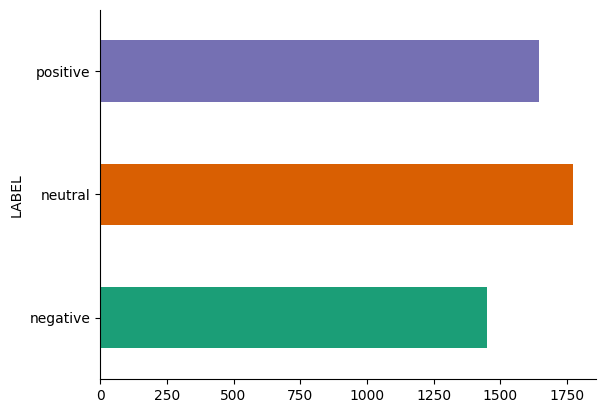

In [10]:
data.groupby('LABEL').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Show frequently used tweets before cleaning

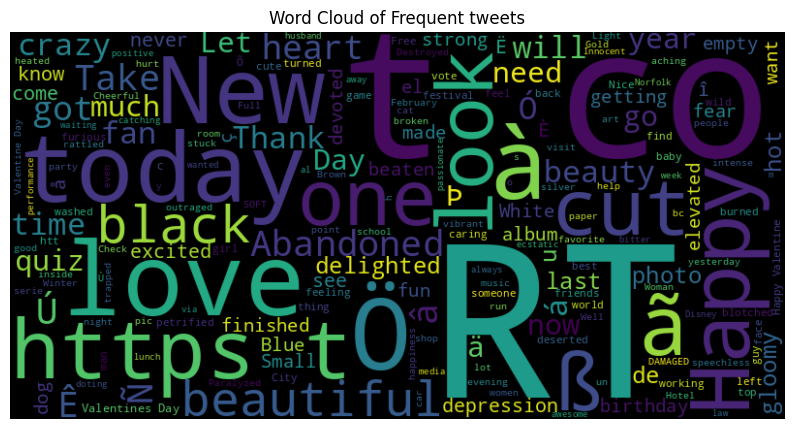

In [45]:
from wordcloud import WordCloud
words = ' '.join([text for text in data['Caption']])
wordcloud = WordCloud(width=800, height=400, random_state=42).generate(words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Frequent tweets')
plt.axis('off')
plt.show()


# Data Cleaning and Preprocessing
In this section we woul remove any unnecessary elements, disturbances and inconsistencies from our text data.###

Creating a Natural Language Processing Pipeline

After loading the data, the following steps are done:


1.   Tokenize the sentences.
2.   Remove stop words.
3.   Normalizing words.
4.   Vectorizing text.


In [11]:
!pip install emoji

The two approaches used were
1. Using the spacy pipeline to perform text cleaning.
2. Usint the regular expression approach.

In [12]:
#cleaning approach using spacy
import re, emoji
def clean_text(text):
  # create an nlp object
  doc = nlp(text)

  # extracted tokens
  tokens = [
      token.lemma_.lower() for token in doc
      if not token.is_stop #removing stop words
      and not token.is_punct #removing punctuation
      and not token.like_num #removing numbers
      and token.is_alpha #keep alphabetic tokens
    ]
    #join tokens to a single string
  cleaned_text = " ".join(tokens)
  return cleaned_text


#cleaning approach using re module
def cleaning(text):
    PATTERN_COMBINED = re.compile(r'''
      @[A-Za-z0-9_]+      # Remove mentions
      | https?://\S+      # Remove URLs
      | RT[\s]+           # Remove retweet indicators
      | [^a-zA-Z\s]       # Remove non-alphabetic characters
      | \#                # Remove hashtag  '#'
  ''', re.VERBOSE)

    text = str(text).lower().strip() #convert to lowercase
    text = emoji.replace_emoji(text, replace='') #remove any emojis found
    text = re.sub(r'\s+', ' ', text).strip() #remove any white spaces found

    return text

# we will drop the first column which contains file names which are not useful in this case
data.drop('File Name', axis=1, inplace=True)

In [13]:
#just to ensure the column was removed
data

,Caption,LABEL
0,How I feel today #legday #jelly #aching #gym,negative
1,@ArrivaTW absolute disgrace two carriages from...,negative
2,This is my Valentine's from 1 of my nephews. I...,positive
3,betterfeelingfilms: RT via Instagram: First da...,neutral
4,Zoe's first love #Rattled @JohnnyHarper15,positive
...,...,...
4864,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive
4865,Feelin' the love in here! #ValentinesDay #caring,positive
4866,#blue #eyes can't be #beaten,neutral
4867,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral


In [14]:
data['cleaned_text'] = data['Caption'].apply(clean_text) #applying cleaning function 1
data['cleaned_text'] = data['cleaned_text'].apply(cleaning) #to remove emoticons

Wordcloud after cleaning

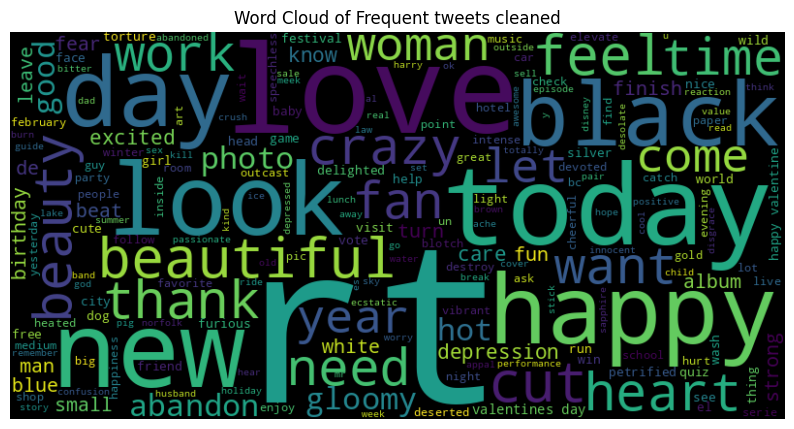

In [47]:
from wordcloud import WordCloud
words = ' '.join([text for text in data['cleaned_text']])
wordcloud = WordCloud(width=800, height=400, random_state=42).generate(words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Frequent tweets cleaned')
plt.axis('off')
plt.show()


In [15]:
encoder = LabelEncoder()
data['LABEL'] = encoder.fit_transform(data['LABEL'])

In [16]:
data

,Caption,LABEL,cleaned_text
0,How I feel today #legday #jelly #aching #gym,0,feel today legday jelly ache gym
1,@ArrivaTW absolute disgrace two carriages from...,0,absolute disgrace carriage bangor half way sta...
2,This is my Valentine's from 1 of my nephews. I...,2,valentine nephew elated little thing big good ...
3,betterfeelingfilms: RT via Instagram: First da...,1,betterfeelingfilm rt instagram day film powerless
4,Zoe's first love #Rattled @JohnnyHarper15,2,zoe love rattle
...,...,...,...
4864,OMG. Well done #Eskom! 'Man dies during #LoadS...,2,omg eskom man die loadshedding powerless
4865,Feelin' the love in here! #ValentinesDay #caring,2,feelin love valentinesday care
4866,#blue #eyes can't be #beaten,1,blue eye beat
4867,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,1,la chucha louuu te chupo los ojos


The Word Embedding methosds applied were:
1. Googles Word2Vec
2. Googles FastText
3. Spacy Tokenization

In [17]:
#applying word embedding methods using googles Word2Vec
#train the model
# https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#TF-IDF_vs_Word2Vec referrence

model = Word2Vec(data['cleaned_text'],
                 vector_size=100, window=5,
                 min_count=1, workers=4)
#get the vectors for it

def wordvectors(sentence):
  return [model.wv[word] for word in sentence if word in model.wv]

data['word2_vec'] = data['cleaned_text'].apply(wordvectors)

In [18]:
#applying word embedding using fast text
#train the model
# https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#TF-IDF_vs_Word2Vec referrence
model = FastText(data['cleaned_text'], vector_size=100,
                 window=5, min_count=1,
                 workers=4)

def fastvectors(sentence):
  return [model.wv[word] for word in sentence if word in model.wv]

data['fast_vec'] = data['cleaned_text'].apply(fastvectors)

In [19]:
#using spacy to do word embeddings
#we use the cleaned column to generate the word embeddings


def spacyvectors(sentence):
  doc = nlp(' '.join(sentence))
  return [token.vector for token in doc if token.has_vector]

data['spacy_vec'] = data['cleaned_text'].apply(spacyvectors)

In [20]:
data

,Caption,LABEL,cleaned_text,word2_vec,fast_vec,spacy_vec
0,How I feel today #legday #jelly #aching #gym,0,feel today legday jelly ache gym,"[[0.09590373, -0.044955574, 0.120092876, 0.168...","[[0.0023317742, -0.04473352, 0.065896, 0.14384...","[[-1.6603, 7.678, 3.7189, 0.71576, -1.4388, -1..."
1,@ArrivaTW absolute disgrace two carriages from...,0,absolute disgrace carriage bangor half way sta...,"[[-0.12717403, 0.09793339, 0.009243825, -0.103...","[[-0.054672383, 0.07824783, -0.059529975, -0.1...","[[-9.3629, 9.2761, -7.2708, 4.3879, 10.316, -6..."
2,This is my Valentine's from 1 of my nephews. I...,2,valentine nephew elated little thing big good ...,"[[0.14792898, 0.010043985, 0.22437343, 0.17499...","[[0.007917864, -0.051663246, 0.1264211, 0.1882...","[[-11.003, -4.2852, 10.258, -0.90299, -4.0383,..."
3,betterfeelingfilms: RT via Instagram: First da...,1,betterfeelingfilm rt instagram day film powerless,"[[0.1917122, -0.036741957, 0.08551804, 0.16448...","[[0.21428561, -0.02121601, 0.011659697, 0.1274...","[[-7.429, 5.7698, 2.2488, -0.8711, 3.5841, -5...."
4,Zoe's first love #Rattled @JohnnyHarper15,2,zoe love rattle,"[[-0.08178961, -0.09588927, 0.24877608, 0.0282...","[[-0.080657944, -0.14152214, 0.25700906, 0.081...","[[-4.5769, 10.807, 2.1575, 4.2887, 5.192, -1.0..."
...,...,...,...,...,...,...
4864,OMG. Well done #Eskom! 'Man dies during #LoadS...,2,omg eskom man die loadshedding powerless,"[[-0.03185357, 0.038424756, -0.013232855, 0.05...","[[-0.10409669, 0.017105741, -0.067761086, -0.0...","[[2.791, 5.3418, 2.0174, 2.1968, 1.6055, -3.15..."
4865,Feelin' the love in here! #ValentinesDay #caring,2,feelin love valentinesday care,"[[0.09590373, -0.044955574, 0.120092876, 0.168...","[[0.0023317742, -0.04473352, 0.065896, 0.14384...","[[-1.6603, 7.678, 3.7189, 0.71576, -1.4388, -1..."
4866,#blue #eyes can't be #beaten,1,blue eye beat,"[[0.1917122, -0.036741957, 0.08551804, 0.16448...","[[0.21428561, -0.02121601, 0.011659697, 0.1274...","[[-7.429, 5.7698, 2.2488, -0.8711, 3.5841, -5...."
4867,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,1,la chucha louuu te chupo los ojos,"[[0.10884103, -0.033621516, 0.09559184, 0.1295...","[[0.14613208, -0.11496039, 0.025176642, 0.1365...","[[2.3673, 5.1357, 2.951, -3.0502, -11.147, -2...."


I use t-Distributed Stochastic Neighbor Embedding to see how the data is arranged in a high demensional space. I am trying to see how the data is segmented and from the results below we can see that there is not much segmentation as they are grouped together.

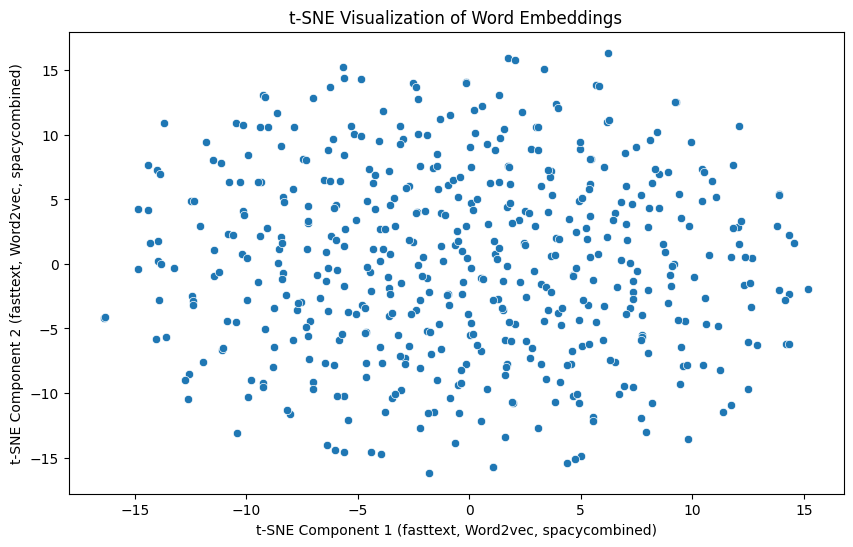

In [29]:
# to compare the rsults of the word embeddings I use visualization techniques to display relationships and clusters

#using t-SNE to visualize word embeddings in a scatter plot
# https://medium.com/@violante.andre/an-introduction-to-t-sne-with-python-example-47e6ae7dc58f refference

from sklearn.manifold import TSNE

#convert the list vectors to numpy arrays
data['fast_vec'] = [np.random.rand(100) for _ in range(len(data))]
data['word2_vec'] = [np.random.rand(100) for _ in range(len(data))]
data['spacy_vec'] = [np.random.rand(100) for _ in range(len(data))]

data_samples = data.sample(n=500, random_state=42) # drop the number of samples used
data = data_samples

# Concatenate the embeddings into a 2D array
embeddings = np.array(data[['fast_vec', 'word2_vec', 'spacy_vec']].apply(lambda x: np.concatenate(x), axis=1).tolist())

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=42)  # random_state for reproducibility
reduced_vectors = tsne.fit_transform(embeddings)

# Create a scatter plot of the t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_vectors[:, 0], y=reduced_vectors[:, 1], palette="deep")
plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Component 1 (fasttext, Word2vec, spacycombined)")
plt.ylabel("t-SNE Component 2 (fasttext, Word2vec, spacycombined)")
plt.show()

cosine similarity is then employed to see how the embeddings of Word2vec, Glove and spacy compare to each other.

In [35]:
#cosine similarity
#https://memgraph.com/blog/cosine-similarity-python-scikit-learn


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

fast_vecs = np.array(data['fast_vec'].tolist())
spacy_vecs = np.array(data['spacy_vec'].tolist())
word2_vecs = np.array(data['word2_vec'].tolist())

similarity_fast_spacy = cosine_similarity(fast_vecs, spacy_vecs)
similarity_fast_word2 = cosine_similarity(fast_vecs, word2_vecs)
similarity_spacy_word2 = cosine_similarity(spacy_vecs, word2_vecs)

In [36]:
#converting similarity scores to percentage
similarity_fast_spacy_percent = similarity_fast_spacy * 100
similarity_fast_word2_percent = similarity_fast_word2 * 100
similarity_spacy_word2_percent = similarity_spacy_word2 * 100

print(f"similarity score of Fast Text to spacy {similarity_fast_spacy_percent}%")
print(f"similarity score of Fast Text to Word2Vec {similarity_fast_word2_percent}%")
print(f"similarity score of spacy and word2vec {similarity_spacy_word2_percent}%")


similarity score of Fast Text to spacy [[75.68091815 73.77820113 79.36665888 ... 75.92569905 74.77097462
  78.1145791 ]
 [78.78144558 77.25941706 78.70215619 ... 74.41482167 75.88747525
  75.54239815]
 [74.1208988  76.43755427 78.138254   ... 72.64507319 76.35044693
  75.17666042]
 ...
 [74.60538467 66.2869101  74.23340545 ... 70.89058769 69.71104243
  72.22189604]
 [73.98749813 66.12857143 78.36517671 ... 75.72563927 76.13941545
  73.76651153]
 [76.81082979 74.73000427 80.34793817 ... 75.98896314 77.90975478
  75.54967859]]%
similarity score of Fast Text to Word2Vec [[76.09206687 73.380502   73.7501683  ... 78.10303345 77.72139265
  72.45264567]
 [78.49864792 72.81237458 79.50388641 ... 77.82089867 74.05176617
  71.19943704]
 [69.69058506 75.54387243 74.65965614 ... 79.03423302 81.85410212
  70.5976842 ]
 ...
 [72.73006765 72.37689215 80.77195124 ... 77.59595654 76.65991311
  77.55087316]
 [73.94566023 76.77822754 78.49637087 ... 75.00015579 78.39898813
  72.60467948]
 [73.44718536 77

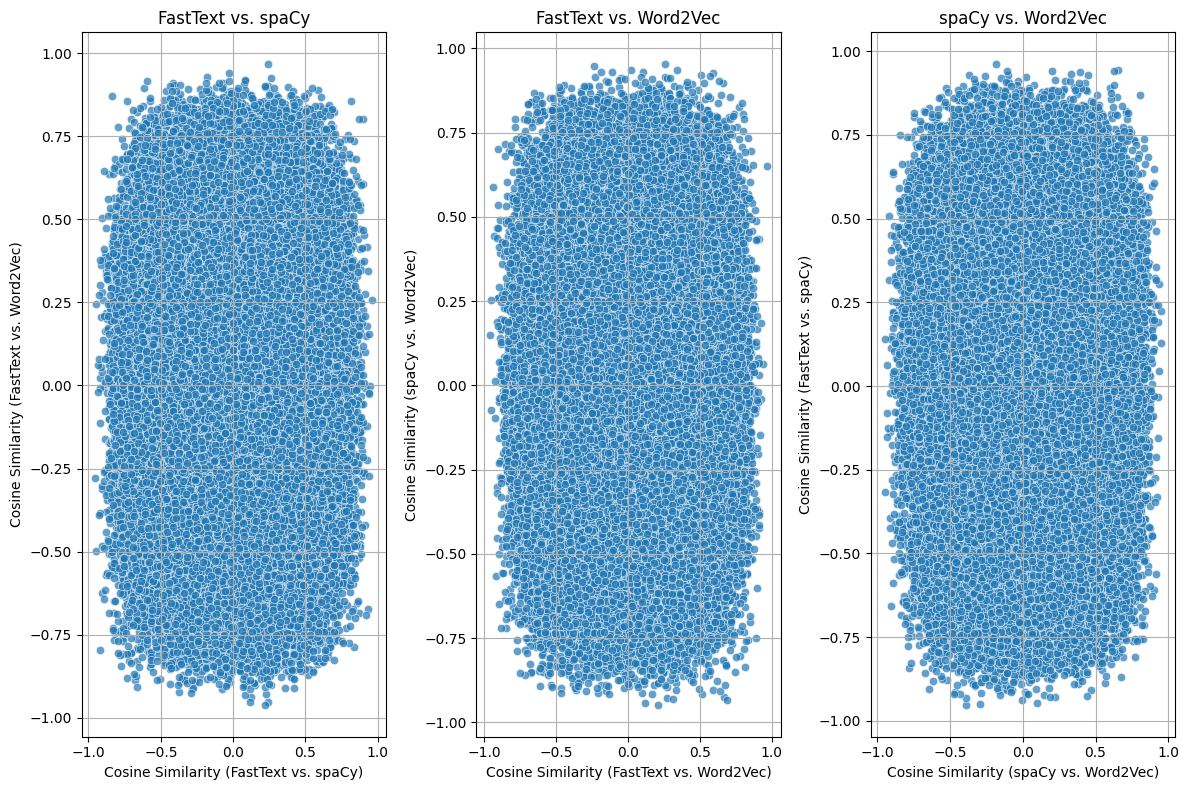

In [39]:
# Flatten the similarity matrices
fast_spacy_flat = similarity_fast_spacy.flatten()
fast_word2_flat = similarity_fast_word2.flatten()
spacy_word2_flat = similarity_spacy_word2.flatten()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'FastText vs. spaCy': fast_spacy_flat,
    'FastText vs. Word2Vec': fast_word2_flat,
    'spaCy vs. Word2Vec': spacy_word2_flat
})

# Create a scatter plot
plt.figure(figsize=(12, 8))

# Scatter plot for FastText vs. spaCy
plt.subplot(1, 3, 1)
sns.scatterplot(data=plot_data, x='FastText vs. spaCy', y='FastText vs. Word2Vec', alpha=0.7)
plt.title("FastText vs. spaCy")
plt.xlabel("Cosine Similarity (FastText vs. spaCy)")
plt.ylabel("Cosine Similarity (FastText vs. Word2Vec)")
plt.grid(True)

# Scatter plot for FastText vs. Word2Vec
plt.subplot(1, 3, 2)
sns.scatterplot(data=plot_data, x='FastText vs. Word2Vec', y='spaCy vs. Word2Vec', alpha=0.7)
plt.title("FastText vs. Word2Vec")
plt.xlabel("Cosine Similarity (FastText vs. Word2Vec)")
plt.ylabel("Cosine Similarity (spaCy vs. Word2Vec)")
plt.grid(True)

# Scatter plot for spaCy vs. Word2Vec
plt.subplot(1, 3, 3)
sns.scatterplot(data=plot_data, x='spaCy vs. Word2Vec', y='FastText vs. spaCy', alpha=0.7)
plt.title("spaCy vs. Word2Vec")
plt.xlabel("Cosine Similarity (spaCy vs. Word2Vec)")
plt.ylabel("Cosine Similarity (FastText vs. spaCy)")
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

A scatter plot is used to show the various relationships

## Final Report and conclusions

This project aimed to analyze the sentiment of tweets using machine learning techniques, with a focus on preprocessing, word embedding, and model evaluation.

##### Summary of Steps:
1. **Data Cleaning**:Two cleaning methods were applied to process tweets.
2. **Feature Extraction**: three word embedding methods namely word2vec, spacy and glove were used to transform text into what machines can understand
3. **Visualization**: We employed t-SNE and cosine similarity visualizations to compare embeddings and explore the relationships between words.

##### Key Findings:
- There is little segmentation when visualizing embeddings using t-SNE, which might indicate overlap in sentiment classes.
- The similarity between FastText and SpaCy embeddings suggests that these two methods are more consistent in capturing context.
- Word2Vec, while effective, tends to produce slightly different embeddings from that of fastText and spacy, which may affect sentiment classification performance.

##### Conclusion:
This project successfully demonstrates how different word embeddings influence sentiment analysis.
``
